# Inclusión de bilbiotecas y set de imagenes

In [1]:
#Se va a agregar el drive al entorno para poder mover archivos más facilmente
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


## Inclusión de set de imagenes y las etiquetas

Se tienen dos opciones para subir las imagenes y las etiquetas a la nuve

La primera opción es descargar directamente del link dado en el github y subirlas como un archivo zip y agregarlos a la nube como se muestra a continuación:

In [2]:
#Para facilidad se sugiere subir al drive personal el DataSet de los Simpsons en un zip y descomprimirlo en ruta aquí
#Este pesa cerca de 1GB pero no va a consumir más memoria que eso

#Instruccion cp de copiado, se sigue de la direccion en la que se tiene el zip con los datos
#y se copia directamente en ./content con el mismo nombre
#Para este ejemplo, el nombre del zip es "Images_Simpsons.zip"
!cp /content/drive/'My Drive'/CoffeeCoffee/Images_Simpsons.zip Images_Simpsons.zip
print('Copy done!')

#Instruccion unzip para descomprimir -qq es la opción de silenciar salida, así no hay tanto ruido
!unzip -qq Images_Simpsons.zip
print('Unzip done!')

Copy done!
Unzip done!


La segunda opción es descargarlos directamente desde el link de dropbox que se da a continuación, aunque esta opción no se recomienda si se ha hecho modificaciones al set de datos.

In [0]:
#Descarga directamente el set de datos y etiquetas
!wget -c https://www.dropbox.com/s/q2nu20ucnpergu3/Images_Simpsons.zip
print('Copy done!')

#Instruccion unzip para descomprimir -qq es la opción de silenciar salida, así no hay tanto ruido
!unzip SimpsonRecognition-master.zip
print('Unzip done!')

## Inclusión de bibliotecas

In [3]:
#Se importan las bibliotecas. En caso de querer hacer este proceso directamente
#en un ordenador se deben instalar las bilbiotecas que se indican a continuacion:

import numpy as np
import cv2
import matplotlib.pyplot as plt
import pickle
import h5py
import sklearn
import glob
import keras
import time
import imp
import os
import tensorflow as tf 
import pandas as pd

#Estas bibliotecas no son necesarias en su totalidad, solo se requieren ciertas
#funciones
from random import shuffle
from skimage import io
from collections import Counter
from PIL import Image, ImageFont, ImageDraw, ImageEnhance

#Importe de funciones especificas de bibliotecas ya importadas
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler, ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import SGD, Adam

#lineas requeridas solo en jupyter notbook
%matplotlib inline
%tensorflow_version 2.x

Using TensorFlow backend.


# Manejo de datos, entrenamiento y pruebas

## Lectura y preprocesado de datos

In [4]:
#Se inicia definiendo el diccionario map_characters, si se agrega otro personaje 
#se debe agregar al diccionario y colocarsele otro numero que no este en uso
characters = [k.split('/')[2] for k in glob.glob('./characters/*') if len([p for p in glob.glob(k+'/*') if 'edited' in p or 'pic_vid' in p]) > 290]
map_characters = dict(enumerate(characters))
map_characters = {0: 'abraham_grampa_simpson', 
                  1: 'apu_nahasapeemapetilon', 
                  2: 'bart_simpson',
                  3: 'charles_montgomery_burns', 
                  4: 'chief_wiggum', 
                  5: 'comic_book_guy', 
                  6: 'edna_krabappel', 
                  7: 'homer_simpson', 
                  8: 'kent_brockman', 
                  9: 'krusty_the_clown', 
                  10: 'lisa_simpson', 
                  11: 'marge_simpson', 
                  12: 'milhouse_van_houten', 
                  13: 'moe_szyslak', 
                  14: 'ned_flanders', 
                  15: 'nelson_muntz', 
                  16: 'principal_skinner', 
                  17: 'sideshow_bob'}

#Se define el numero de clases con la extensión del diccionario
num_classes = len(map_characters)

#Número máximo de imagenes que se usaran por personaje para entrenar
pictures_per_class = 1000

def load_pictures(test_size, pic_size,BGR):
    """
    Load pictures from folders for characters from the map_characters dict and create a numpy dataset and 
    a numpy labels set. Pictures are re-sized into picture_size square.
    :param BGR: boolean to use true color for the picture (RGB instead of BGR for plt)
    :return: dataset, labels set
    """
    pics = []    #Se crea la lista de imagenes de salida
    labels = []  #Se crea la lista de etiquetas de salida

    #k es el numero de la variable en el diccionario
    #char es el nombre de la variable en el diccionario
    # El if lo que hace es que recorra cada una de las variables del diccionario
    for k, char in map_characters.items(): 

        #Esta linea deivuelve la lista de rutas de las imagenes de cada personaje del diccionario
        # Ej: para char = 'abraham_grampa_simpson' regresa todas las rutas de imagen de la carpeta
        # abraham_grampa_simpson que a su vez esta en la carpeta characters.
        #Es solo una forma elegante y rapida de optener todas las rutas 
        pictures = [k for k in glob.glob('./characters/%s/*' % char)]

        #Se establece la cantidad de imagenes que se van a usar en cada clase
        #Como maximo se usan 1176 imagenes, estas son tanto para train como para test
        #Si el personaje en particular tiene menos de 1176 imagenes se usara la extension del personaje en cuestion
        nb_pic = round(pictures_per_class/(1-test_size)) if round(pictures_per_class/(1-test_size))<len(pictures) else len(pictures)

        #Se usa la funcion random para ordenar de manera aleatoria las imagenes de cada personaje
        #Cabe detacar que pic es una ruta de acceso aleatoria de la lista de rutas de acceso en pictures
        for pic in np.random.choice(pictures, nb_pic):

            #Se lee la imagen de la ruta "pic"
            a = cv2.imread(pic)

            #Si se desea se usa RGB se hace la transformacion de BGR, que es la lectura original
            #Por defecto este cambio no se hace a menos que se especifique
            if BGR:
                a = cv2.cvtColor(a, cv2.COLOR_BGR2RGB)
            
            #Se hace un resize de las imagenes a pic_size x pic_size. Por defecoto
            #este es 64x64. Esto concuerda con los pixeles de entrada de la red neuronal
            a = cv2.resize(a, (pic_size,pic_size))

            #Se agrega la imagen leida, convertida y escalada a la lista pics
            pics.append(a)
            #Se agrega la etiqueta numérica de la lista de etiquetas, esta etiqueta numerica 
            #concuerda con el número en el diccionario map_characters
            labels.append(k)

    #Se devuelve las listas pero antes se transforman a un formato de array con numpy
    return np.array(pics), np.array(labels) 

def get_dataset(save=False, load=False, BGR=False, test_size=0.15, pic_size=64):
    """
    Create the actual dataset split into train and test, pictures content is as float32 and
    normalized (/255.). The dataset could be saved or loaded from h5 files.
    :param save: saving or not the created dataset
    :param load: loading or not the dataset
    :param BGR: boolean to use true color for the picture (RGB instead of BGR for plt)
    :return: X_train, X_test, y_train, y_test (numpy arrays)
    """
    #Si ya se tienen listos de antemano se cargan directamente de memoria, por 
    #defecto esta opcion esta desactivada
    if load:
        #Se lee directamente el archivo 'dataset.h5', aqui estan tanto el set de 
        #entrenamiento como el de test 
        h5f = h5py.File('dataset.h5','r')
        
        #Se divide entre set de train y set de test, esto gracias a la etiqueta
        #que el archivo .h5 trae, similar a un formato .json
        X_train = h5f['X_train'][:]
        X_test = h5f['X_test'][:]
        h5f.close()

        #Se hace un proceso igual pero para los labels
        h5f = h5py.File('labels.h5','r')
        y_train = h5f['y_train'][:]
        y_test = h5f['y_test'][:]
        h5f.close()    
    
    #En caso de que no esten en memoria los sets de entrenamiento y test se 
    #realiza todo el procesamiento desde cero
    else:
        #Primero se llama a la funcion load_pictures, por defecto se deja estas en 
        #blanco y negro
        #En esta funcion tambien se extraen los labels del archivo txt anotations
        X, y = load_pictures(test_size, pic_size, BGR)

        #Luego se pasa los labels a un formato numerico y en listas separadas,
        #por ejemplo si el label es 2 to_categorical lo pasa a una lista [0 0 1 ... 0]
        #El tamaño de la lista depende de cuantas clases se tenga, en este ejemplo son 18
        y = keras.utils.to_categorical(y, num_classes)

        #Posteriormente se divide todos los datos en set de train y test, el tamaño del
        #set de test esta dado por la variable test_size, por defecto es 15%
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
        
        #Se guarda los sets creados en archivos con formato .h5, tanto los labels como
        #las imagenes
        if save:
            h5f = h5py.File('dataset.h5', 'w')
            h5f.create_dataset('X_train', data=X_train)
            h5f.create_dataset('X_test', data=X_test)
            h5f.close()

            h5f = h5py.File('labels.h5', 'w')
            h5f.create_dataset('y_train', data=y_train)
            h5f.create_dataset('y_test', data=y_test)
            h5f.close()

    #Se normaliza las imagenes para que los valores de cada banda esten en punto flotante
    #y además se encuentren entre 0 y 1. Esto ayuda a la velocidad de entrenamiento           
    X_train = X_train.astype('float32') / 255.
    X_test = X_test.astype('float32') / 255.
    
    #Se imprime las formas de cada tensor. Si se mantienen todas las variables 
    #por defecto estas deben ser (x,64,64,3) y (x,w), donde x es el numero de imagenes
    #y w es la cantidad de clases en el diccionario
    print("Train", X_train.shape, y_train.shape)
    print("Test", X_test.shape, y_test.shape)

    #Imprime la cantidad de imagenes por personaje y la cantidad de imagenes en 
    #que se pusieron en el set de train y en el set de test
    if not load:
        #Se crea un diccionario donde cada variable esta asociada a una lista que contiene la extension del set
        #de train y test para cada personaje
        dist = {k:tuple(d[k] for d in [dict(Counter(np.where(y_train==1)[1])), dict(Counter(np.where(y_test==1)[1]))]) 
                for k in range(num_classes)}

        #Se imprime en orden decendente
        print('\n'.join(["%s : %d train pictures & %d test pictures" % (map_characters[k], v[0], v[1]) 
            for k,v in sorted(dist.items(), key=lambda x:x[1][0], reverse=True)]))
    
    #Se devuelve los set de datos divididas en train y test. Esto tanto para las 
    #imagenes como para los labels.
    return X_train, X_test, y_train, y_test

#Uso de funciones de lectura para dividir el set de imagnes en test y train
X_train, X_test, y_train, y_test = get_dataset(save=True)

Train (14317, 64, 64, 3) (14317, 18)
Test (2527, 64, 64, 3) (2527, 18)
ned_flanders : 1017 train pictures & 159 test pictures
homer_simpson : 1011 train pictures & 165 test pictures
moe_szyslak : 1007 train pictures & 169 test pictures
lisa_simpson : 1001 train pictures & 175 test pictures
bart_simpson : 994 train pictures & 182 test pictures
marge_simpson : 994 train pictures & 182 test pictures
principal_skinner : 993 train pictures & 183 test pictures
charles_montgomery_burns : 984 train pictures & 192 test pictures
krusty_the_clown : 984 train pictures & 192 test pictures
milhouse_van_houten : 925 train pictures & 154 test pictures
chief_wiggum : 833 train pictures & 153 test pictures
abraham_grampa_simpson : 800 train pictures & 113 test pictures
sideshow_bob : 734 train pictures & 143 test pictures
apu_nahasapeemapetilon : 533 train pictures & 90 test pictures
kent_brockman : 420 train pictures & 78 test pictures
comic_book_guy : 394 train pictures & 75 test pictures
edna_krabapp

## Creacion de redes neuronales (CNN)

In [0]:
def create_model_four_conv(input_shape):
    """
    CNN Keras model with 4 convolutions.
    :param input_shape: input shape, generally X_train.shape[1:]
    :return: Keras model, RMS prop optimizer
    """

    #Se crea primeramente un modelo "Sequential", este es el tipo de red neuronal
    #existen otros tipos como las recursivas y las recurrentes.

    model = Sequential()
    
    #Se usa mucho las capas Conv2D, por lo que se explicara solo una vez. Estas 
    #tienen el formato por defecto:
    
    #tf.keras.layers.Conv2D(
    #    filters, kernel_size, strides=(1, 1), padding='valid', data_format=None,
    #    dilation_rate=(1, 1), activation=None, use_bias=True,
    #    kernel_initializer='glorot_uniform', bias_initializer='zeros',
    #    kernel_regularizer=None, bias_regularizer=None, activity_regularizer=None,
    #    kernel_constraint=None, bias_constraint=None, **kwargs)
    #
    # Donde:
    #"filters" se refiere a la cantidad de filtros que se tienen en esa capa, 
    #por ejemplo en la primera capa se tiene 32 filtros.
    #Los filtros son los que cambuan durante el entrenamiento.
    
    #"strides" es siempre una tupla. Se refiere a las dimenciones dadas para 
    #cada filtro, por defecto esta variable tiene como valor la tupla (1,1). 
    #Por ejemplo, en la primera capa se usa una dimensión para los filtros (3,3)
    
    #"padding" es una bandera que puede ser "valid" (opcion por defecto) 
    #o "same" (case-insensitive). La opción valid tiene la posibilidad de perder
    #informacion de entrada en especial de las esquinas. Por otra parte same
    #aplica rellenos en las esquinas de modo que se usen todos los pixeles de entrada

    #"input_shape" se usa solo en la capa (layer) de entrada

    #¿Que recibe de entrada y que obtiene de salida estas capas?
    #La entrada debe ser un tensor de 4D con el formato:
    #   (batch_size, rows, cols, channels), si data_format='channels_last' esta 
    #     es la opcion por defecto de "data_format"
    #
    #   (batch_size, channels, rows, cols), si data_format='channels_first'
    #
    #La salida es otro tensor de 4D con el formato:
    #   (batch_size, new_rows, new_cols, filters), si data_format='channels_last' 
    #     esta es la opcion por defecto de "data_format"
    #
    #   (batch_size, filters, new_rows, new_cols), si data_format='channels_first' 
    #
    #rows and cols pueden variar dependiendo de la bandera "padding", con "same"
    #se tendrian la misma candtidad de rows y cols de salida que de entrada.

    #Primera capa convolucional
    model.add(Conv2D(32, (3, 3), padding='same', input_shape=input_shape))

    #Se agrega una funcion de activacion, se puede agregar directamente en la capa
    #convolucional pero esto haria que se pusiera la activacion en la entrada, 
    #se decide poner la activacion en la salida

    model.add(Activation('relu'))

    #Segunda capa convolucional, con 32 filtros
    model.add(Conv2D(32, (3, 3)))
    model.add(Activation('relu'))
    
    #Una capa Maxpolling2D reduce la cantidad de col y rows, en este caso
    #se reduce de una matriz 2x2 a un unico escalar
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    #Tercera capa convolucional, con 64 filtros
    model.add(Conv2D(64, (3, 3), padding='same'))
    model.add(Activation('relu'))
    
    #Cuarta capa convolucional, con 64 filtros
    model.add(Conv2D(64, (3, 3)))
    model.add(Activation('relu'))

    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    
    model.add(Dense(512))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))

    model.add(Dense(num_classes))
    model.add(Activation('softmax'))
    
    #Se define la funcion de optimización
    opt = keras.optimizers.rmsprop(lr=0.0001, decay=1e-6)
    return model, opt

def create_model_six_conv(input_shape):
    """
    CNN Keras model with 6 convolutions.
    :param input_shape: input shape, generally X_train.shape[1:]
    :return: Keras model, RMS prop optimizer
    """
    model = Sequential()
    model.add(Conv2D(32, (3, 3), padding='same', input_shape=input_shape))
    model.add(Activation('relu'))
    model.add(Conv2D(32, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))

    model.add(Conv2D(64, (3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(Conv2D(64, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))

    model.add(Conv2D(256, (3, 3), padding='same')) 
    model.add(Activation('relu'))
    model.add(Conv2D(256, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))

    model.add(Flatten())
    model.add(Dense(1024))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    opt = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
    return model, opt

## Funciones de entrenamiento

In [0]:
pic_size = 64
batch_size = 32
epochs = 2
num_classes = len(map_characters)
pictures_per_class = 1000
test_size = 0.15

def load_model_from_checkpoint(weights_path, six_conv=False, input_shape=(pic_size,pic_size,3)):
    if six_conv:
        model, opt = create_model_six_conv(input_shape)
    else:
        model, opt = create_model_four_conv(input_shape)
    model.load_weights(weights_path)
    model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])
    return model

def lr_schedule(epoch):
    lr = 0.01
    return lr*(0.1**int(epoch/10))

def training(model, X_train, X_test, y_train, y_test, data_augmentation=True, epochs=40):
    """
    Training.
    :param model: Keras sequential model
    :param data_augmentation: boolean for data_augmentation (default:True)
    :param callback: boolean for saving model checkpoints and get the best saved model
    :param six_conv: boolean for using the 6 convs model (default:False, so 4 convs)
    :return: model and epochs history (acc, loss, val_acc, val_loss for every epoch)
    """
    if data_augmentation:
        datagen = ImageDataGenerator(
            featurewise_center=False,  # set input mean to 0 over the dataset
            samplewise_center=False,  # set each sample mean to 0
            featurewise_std_normalization=False,  # divide inputs by std of the dataset
            samplewise_std_normalization=False,  # divide each input by its std
            zca_whitening=False,  # apply ZCA whitening
            rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
            width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
            height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
            horizontal_flip=True,  # randomly flip images
            vertical_flip=False)  # randomly flip images
        # Compute quantities required for feature-wise normalization
        # (std, mean, and principal components if ZCA whitening is applied).
        datagen.fit(X_train)
        filepath="weights_test.hdf5"
        checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=0, save_best_only=True, mode='max')
        callbacks_list = [LearningRateScheduler(lr_schedule) ,checkpoint]
        
        history = model.fit_generator(datagen.flow(X_train, y_train,
                                    batch_size=batch_size),
                                    steps_per_epoch=X_train.shape[0] // batch_size,
                                    epochs=epochs,
                                    validation_data=(X_test, y_test),
                                    callbacks=callbacks_list)        
    else:
        history = model.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(X_test, y_test),
          shuffle=True)
    return model, history


In [17]:
## Training in the notebook
epochs_num = 60
model, opt = create_model_six_conv(X_train.shape[1:])
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
model, history = training(model, X_train, X_test, y_train, y_test, data_augmentation=True, epochs=epochs_num)

Epoch 1/60
447/447 [==============================] - 19s 42ms/step - loss: 2.6080 - accuracy: 0.1777 - val_loss: 2.1171 - val_accuracy: 0.3732
Epoch 2/60
  2/447 [..............................] - ETA: 32s - loss: 2.3193 - accuracy: 0.2969

/usr/local/lib/python3.6/dist-packages/keras/callbacks/callbacks.py:707: RuntimeWarning: Can save best model only with val_acc available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


447/447 [==============================] - 19s 42ms/step - loss: 2.0578 - accuracy: 0.3623 - val_loss: 1.6886 - val_accuracy: 0.4780
Epoch 3/60
447/447 [==============================] - 19s 42ms/step - loss: 1.6677 - accuracy: 0.4915 - val_loss: 1.3011 - val_accuracy: 0.6161
Epoch 4/60
447/447 [==============================] - 19s 42ms/step - loss: 1.3402 - accuracy: 0.5936 - val_loss: 1.0070 - val_accuracy: 0.6925
Epoch 5/60
447/447 [==============================] - 19s 42ms/step - loss: 1.0880 - accuracy: 0.6708 - val_loss: 0.7461 - val_accuracy: 0.7736
Epoch 6/60
447/447 [==============================] - 18s 41ms/step - loss: 0.8970 - accuracy: 0.7275 - val_loss: 0.6579 - val_accuracy: 0.7982
Epoch 7/60
447/447 [==============================] - 18s 41ms/step - loss: 0.7564 - accuracy: 0.7688 - val_loss: 0.5152 - val_accuracy: 0.8472
Epoch 8/60
447/447 [==============================] - 18s 41ms/step - loss: 0.6520 - accuracy: 0.7999 - val_loss: 0.4702 - val_accuracy: 0.8520
Epo

In [0]:
pd.DataFrame.from_dict(history.history).to_csv('history.csv',index=False)
data = pd.read_csv("history.csv")

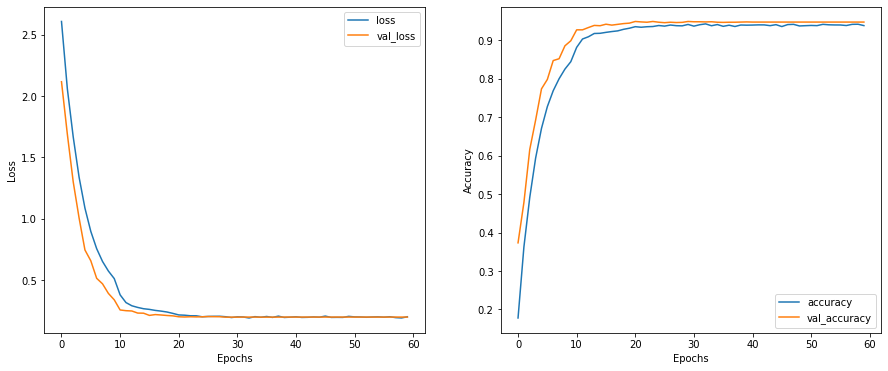

In [19]:
epochs= range(epochs_num)
f, ax = plt.subplots(ncols=2, figsize=(15,6))
ax[0].plot(epochs, data['loss'], label='loss')
ax[0].plot(epochs, data['val_loss'], label='val_loss')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].legend()
ax[1].plot(epochs, data['accuracy'], label='accuracy')
ax[1].plot(epochs, data['val_accuracy'], label='val_accuracy')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy')
ax[1].legend()

In [20]:
results = model.evaluate(X_test, y_test, batch_size=128)
print('test loss, test acc:', results)

2527/2527 [==============================] - 0s 175us/step
test loss, test acc: [0.19944200934241493, 0.9473684430122375]


In [0]:
model.save('New.h5')

In [0]:
!cp New.h5 /content/drive/'My Drive'/CoffeeCoffee/New.h5
!cp history.csv /content/drive/'My Drive'/CoffeeCoffee/history.csv

In [0]:
def plot_and_predict(image, model, BGR=False, pic_size=64 ,all_perc=False):
    pics = []
    img = io.imread(image)
    plt.imshow(img)
    plt.show()
    
    #Lectura de la imagen con OpenCV
    a = cv2.imread(image)

    #Esto es importante, si se entreno en blanco y negro se debe hacer la lectura
    #en blanco y negro, por defecto esta en blanco y negro BGR = False
    if BGR:
        a = cv2.cvtColor(a, cv2.COLOR_BGR2RGB)

    #Se hace el resize a pic_size x pic_size por defecto esto es 64x64 
    a = cv2.resize(a, (pic_size,pic_size))    

    #Se le da el formato adecuado
    #Primero se convierte en lista
    #Para que tenga forma (1,pic_size,pic_size,3) que es el shape que 
    #requiere la red, por defecto esto es (1,64,64,3)
    pics.append(a)

    #Luego se pasa a un numpy array que es el formato requerido
    pics_format = np.array(pics)

    #Finalmente se normaliza cada banda en numeros con punto flotantes entre 0 y 1
    pics_format = pics_format.astype('float32') / 255

    Prediction = model.predict(pics_format[[0]])
    return Prediction

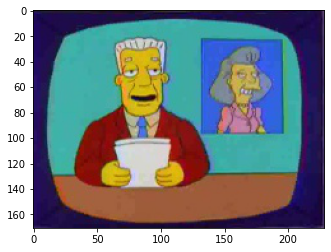

kent brockman


In [24]:
name  = 'kent_brockman_20.jpg'
image = '/content/Extra_Images/'
#image = '/content/characters/abraham_grampa_simpson/'

new_model = keras.models.load_model('New.h5')
predictions = plot_and_predict(image + name, new_model, pic_size=64)
print(map_characters[np.argmax(predictions[0])].replace('_',' '))